# Analysis of Historical Lending Club Data

Import Libraries and read the data.

In [108]:
# Import our libraries we are going to use for our data analysis.
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Plotly visualizations
from chart_studio.plotly import iplot


import chart_studio
chart_studio.tools.set_credentials_file(username='kathryndcf3', api_key='WJsEC99UCtPchVz16wBk')


# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Other Libraries
import time


import matplotlib.pyplot as plt
%matplotlib inline



In [19]:
# Read the dataframe

df = pd.read_csv('input/loan.csv', low_memory=False)

# Copy of the dataframe
original_df = df.copy()

df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [21]:
# Replace the name of some columns
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

# Drop irrelevant columns
df.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)


# Distributions of Loans

Text(0.5, 1.0, 'Total committed by Investors')

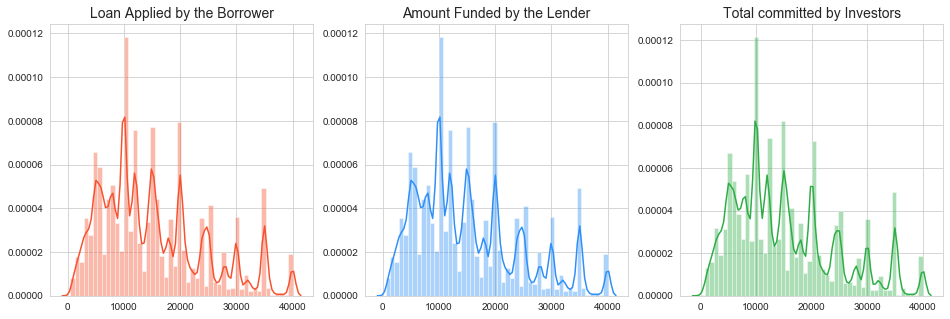

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))




loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values


sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

# Loan Issuance by Year

In [23]:
# Transform the issue dates by year.
df['issue_d'].head()
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

Text(0, 0.5, 'Average loan amount issued')

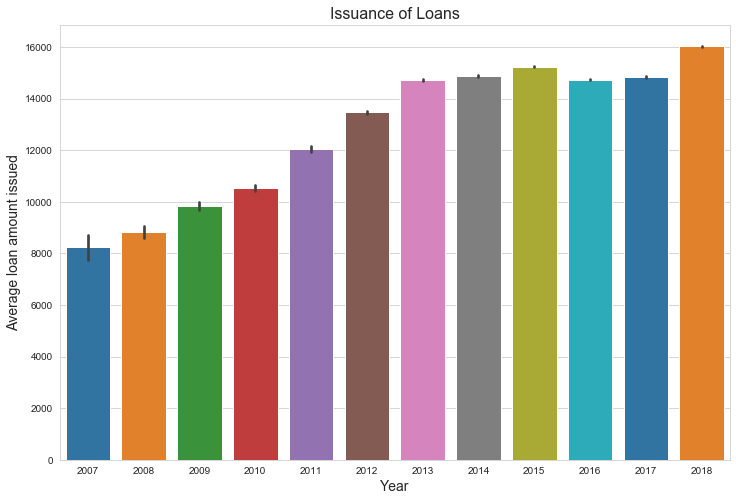

In [111]:

plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amount', data=df, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

# Good Loans vs Bad

In [115]:
df["loan_status"].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [116]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

[Text(0, 0.5, '(%)')]

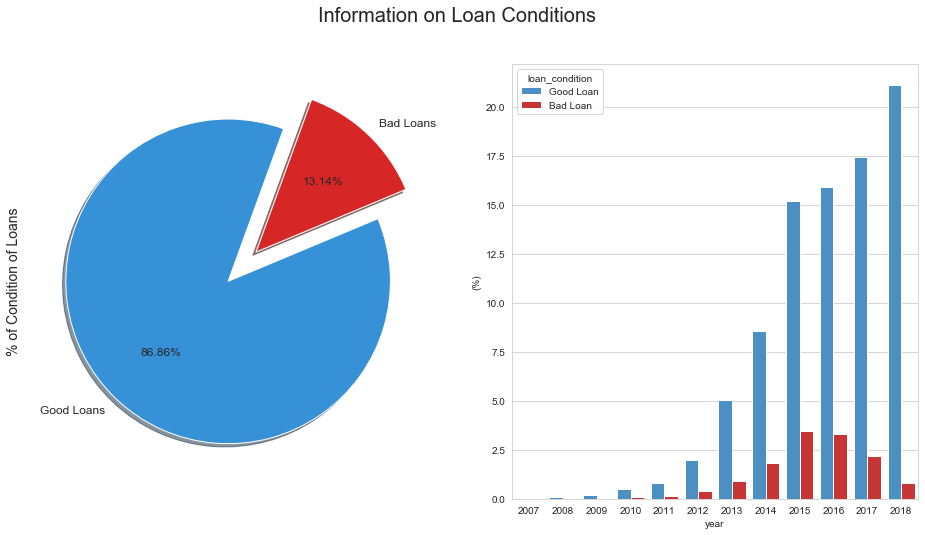

In [117]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

# Loans Issues by Region

In [118]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


df['region'] = df['addr_state'].apply(finding_regions)

In [119]:
# This code will take the current date and transform it into a year-month format
df['complete_date'] = pd.to_datetime(df['issue_d'])

group_dates = df.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['loan_amount'] = group_dates['loan_amount']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','loan_amount']])

Text(0.5, 1.0, 'Loans issued by Region')

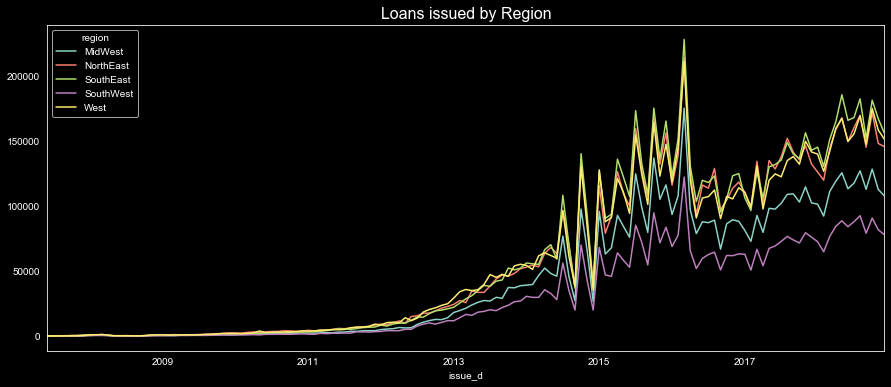

In [120]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).loan_amount.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

In [121]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0
    

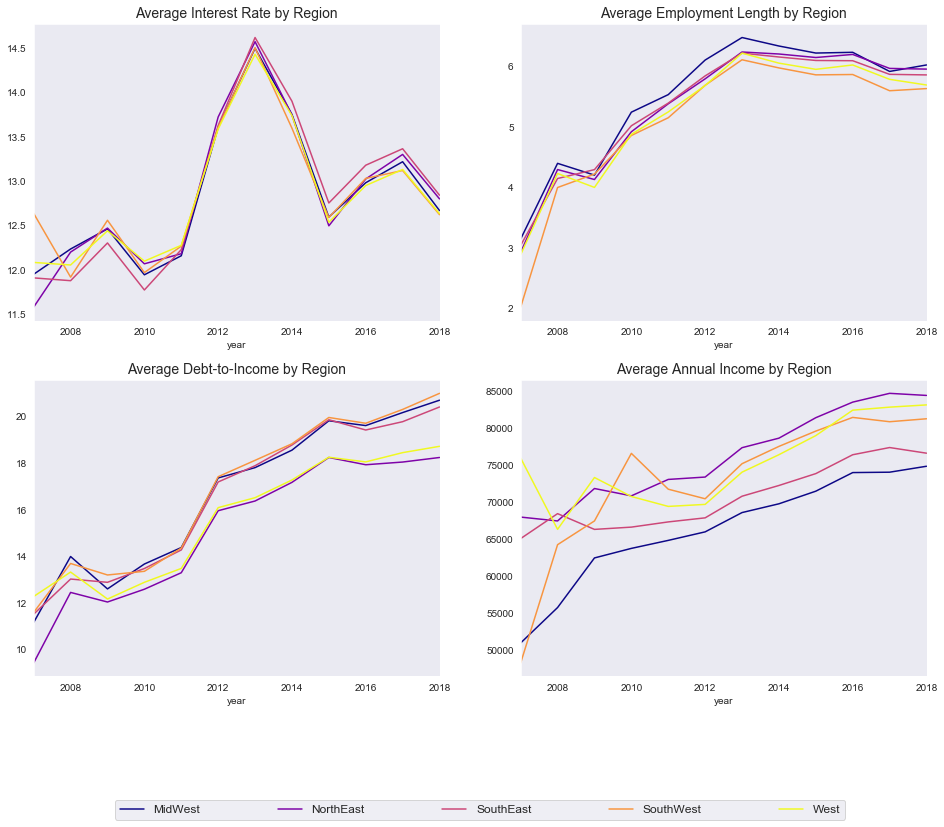

In [169]:
# Loan issued by Region and by Credit Score grade

sns.set_style('darkgrid')


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.plasma

#Average Interest Rate by Region
by_interest_rate = df.groupby(['year', 'region']).interest_rate.mean()
by_interest_rate.unstack().plot( stacked=False, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)

#Average Employment Rate by Region
by_employment_length = df.groupby(['year', 'region']).emp_length_int.mean()
by_employment_length.unstack().plot( stacked=False, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)
# plt.xlabel('Year of Issuance', fontsize=14)

#Average Debt:Income Ratio by Region
by_dti = df.groupby(['year', 'region']).dti.mean()
by_dti.unstack().plot( stacked=False, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

#Average Annual Income by Region
by_income = df.groupby(['year', 'region']).annual_income.mean()
by_income.unstack().plot(stacked=False, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

# Bad Loan Analysis

In [123]:
# We have 67429 loans categorized as bad loans
badloans_df = df.loc[df["loan_condition"] == "Bad Loan"]

# loan_status cross
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])


# Round our values
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['Default'] = loan_status_cross['Default'].apply(lambda x: round(x, 2))
loan_status_cross['Does not meet the credit policy. Status:Charged Off'] = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
# number_of_badloans
number_of_loanstatus

loan_status,Charged Off,Default,Does not meet the credit policy. Status:Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,,,
MidWest,45202,9,142,1449,550,3609,50961
NorthEast,60827,7,190,2356,957,5356,69693
SouthEast,65460,5,184,2359,974,5596,74578
SouthWest,31833,4,79,1009,463,2794,36182
West,58333,6,166,1779,793,4542,65619


In [124]:
charged_off = loan_status_cross['Charged Off'].values.tolist()
default = loan_status_cross['Default'].values.tolist()
not_meet_credit = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].values.tolist()
grace_period = loan_status_cross['In Grace Period'].values.tolist()
short_pay = loan_status_cross['Late (16-30 days)'] .values.tolist()
long_pay = loan_status_cross['Late (31-120 days)'].values.tolist()



charged = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= charged_off,
    name='Charged Off',
    marker=dict(
        color='rgb(192, 148, 246)'
    ),
    text = '%'
)

defaults = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y=default,
    name='Defaults',
    marker=dict(
        color='rgb(176, 26, 26)'
    ),
    text = '%'
)

credit_policy = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= not_meet_credit,
    name='Does not meet Credit Policy',
    marker = dict(
        color='rgb(229, 121, 36)'
    ),
    text = '%'
)

grace = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= grace_period,
    name='Grace Period',
    marker = dict(
        color='rgb(147, 147, 147)'
    ),
    text = '%'
)

short_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= short_pay,
    name='Late Payment (16-30 days)', 
    marker = dict(
        color='rgb(246, 157, 135)'
    ),
    text = '%'
)

long_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= long_pay,
    name='Late Payment (31-120 days)',
    marker = dict(
        color = 'rgb(238, 76, 73)'
        ),
    text = '%'
)




data = [charged, defaults, credit_policy, grace, short_pays, long_pays]
layout = go.Layout(
    barmode='stack',
    title = '% of Bad Loan Status by Region',
    xaxis=dict(title='US Regions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

# Average Income & Interest Rate by State

In [125]:
# Average interest rates clients pay
df['interest_rate'].mean()
# Average annual income of clients
df['annual_income'].mean()

77992.42868706721

In [126]:
# Plotting by states

# Grouping by our metrics
# First Plotly Graph (We evaluate the operative side of the business)
by_loan_amount = df.groupby(['region','addr_state'], as_index=False).loan_amount.sum()
by_interest_rate = df.groupby(['region', 'addr_state'], as_index=False).interest_rate.mean()
by_income = df.groupby(['region', 'addr_state'], as_index=False).annual_income.mean()



# Take the values to a list for visualization purposes.
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amount'].values.tolist()
average_interest_rates = by_interest_rate['interest_rate'].values.tolist()
average_annual_income = by_income['annual_income'].values.tolist()


from collections import OrderedDict

# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])
                     

metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()



,state_codes,issued_loans,interest_rate,annual_income
0,IA,114075,12.63,44756.21
1,IL,1410451950,12.96,79884.92
2,IN,550776675,13.18,70365.19
3,KS,283877825,13.00,71456.55
4,MI,841646100,13.16,71660.97


In [127]:
# Now it comes the part where we plot out plotly United States map


for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_income'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]


layout = dict(
    title = 'Lending Clubs Issued Loans <br> (A Perspective for the Business Operations)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

# Default Rates by State

In [128]:
# Let's create categories for annual_income since most of the bad loans are located below 100k

df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

In [129]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_condition_int'] = df['loan_condition_int'].astype(int)

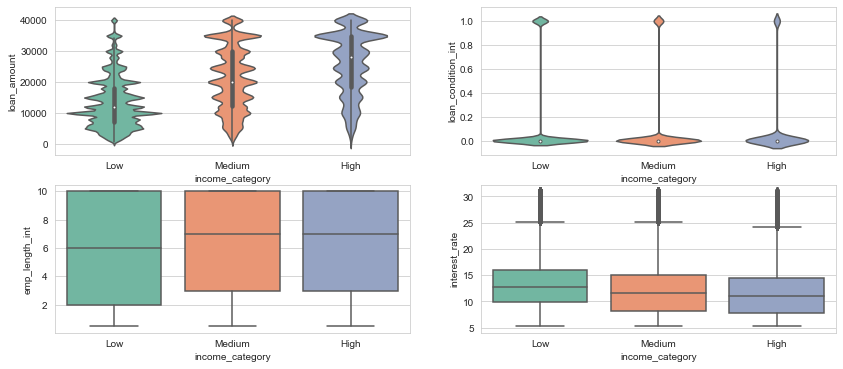

In [130]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, palette="Set2", ax=ax2)
sns.boxplot(x="income_category", y="emp_length_int", data=df, palette="Set2", ax=ax3)
sns.boxplot(x="income_category", y="interest_rate", data=df, palette="Set2", ax=ax4)

In [131]:
by_condition = df.groupby('addr_state')['loan_condition'].value_counts()/ df.groupby('addr_state')['loan_condition'].count()
by_emp_length = df.groupby(['region', 'addr_state'], as_index=False).emp_length_int.mean().sort_values(by="addr_state")

loan_condition_bystate = pd.crosstab(df['addr_state'], df['loan_condition'] )

cross_condition = pd.crosstab(df["addr_state"], df["loan_condition"])
# Percentage of condition of loan
percentage_loan_contributor = pd.crosstab(df['addr_state'], df['loan_condition']).apply(lambda x: x/x.sum() * 100)
condition_ratio = cross_condition["Bad Loan"]/cross_condition["Good Loan"]
by_dti = df.groupby(['region', 'addr_state'], as_index=False).dti.mean()
state_codes = sorted(states)


# Take to a list
default_ratio = condition_ratio.values.tolist()
average_dti = by_dti['dti'].values.tolist()
average_emp_length = by_emp_length["emp_length_int"].values.tolist()
number_of_badloans = loan_condition_bystate['Bad Loan'].values.tolist()
percentage_ofall_badloans = percentage_loan_contributor['Bad Loan'].values.tolist()


# Figure Number 2
risk_data = OrderedDict([('state_codes', state_codes),
                         ('default_ratio', default_ratio),
                         ('badloans_amount', number_of_badloans),
                         ('percentage_of_badloans', percentage_ofall_badloans),
                         ('average_dti', average_dti),
                         ('average_emp_length', average_emp_length)])


# Figure 2 Dataframe 
risk_df = pd.DataFrame.from_dict(risk_data)
risk_df = risk_df.round(decimals=3)
risk_df.head()

,state_codes,default_ratio,badloans_amount,percentage_of_badloans,average_dti,average_emp_length
0,AK,0.153,696,0.234,13.656,6.136
1,AL,0.188,4308,1.450,18.739,6.463
2,AR,0.183,2642,0.889,20.327,6.254
3,AZ,0.150,7028,2.366,20.414,5.680
4,CA,0.155,42319,14.247,19.240,5.947


In [132]:
# Now it comes the part where we plot out plotly United States map




for col in risk_df.columns:
    risk_df[col] = risk_df[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

risk_df['text'] = risk_df['state_codes'] + '<br>' +\
'Number of Bad Loans: ' + risk_df['badloans_amount'] + '<br>' + \
'Percentage of all Bad Loans: ' + risk_df['percentage_of_badloans'] + '%' +  '<br>' + \
'Average Debt-to-Income Ratio: ' + risk_df['average_dti'] + '<br>'+\
'Average Length of Employment: ' + risk_df['average_emp_length'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df['default_ratio'], 
        locationmode = 'USA-states',
        text = risk_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]


layout = dict(
    title = 'Lending Clubs Default Rates <br> (Analyzing Risks)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

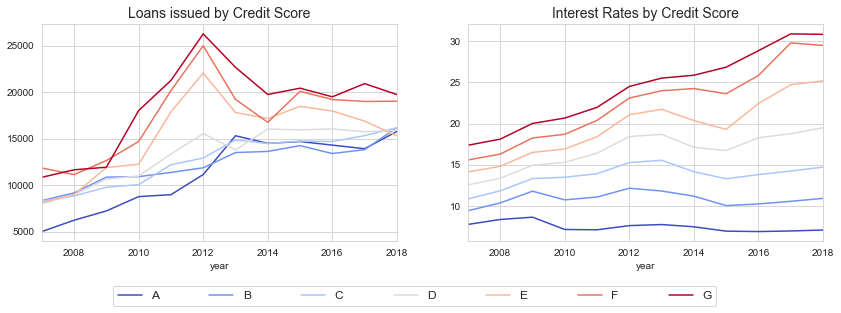

In [133]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

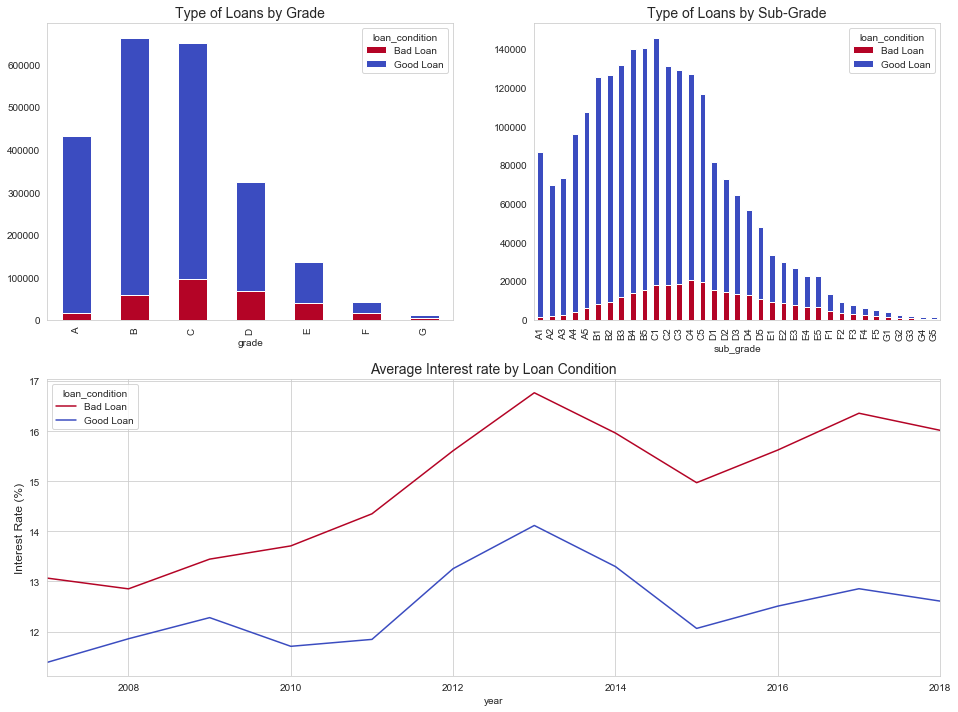

In [134]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

In [135]:
# Just get me the numeric variables
numeric_variables = df.select_dtypes(exclude=["object"])

In [136]:
# We will use df_correlations dataframe to analyze our correlations.


df_correlations = df.corr()


trace = go.Heatmap(z=df_correlations.values,
                   x=df_correlations.columns,
                   y=df_correlations.columns,
                  colorscale=[[0.0, 'rgb(165,0,38)'], 
                              [0.1111111111111111, 'rgb(215,48,39)'], 
                              [0.2222222222222222, 'rgb(244,109,67)'], 
                              [0.3333333333333333, 'rgb(253,174,97)'], 
                              [0.4444444444444444, 'rgb(254,224,144)'], 
                              [0.5555555555555556, 'rgb(224,243,248)'], 
                              [0.6666666666666666, 'rgb(171,217,233)'], 
                              [0.7777777777777778, 'rgb(116,173,209)'], 
                              [0.8888888888888888, 'rgb(69,117,180)'], 
                              [1.0, 'rgb(49,54,149)']],
            colorbar = dict(
            title = 'Level of Correlation',
            titleside = 'top',
            tickmode = 'array',
            tickvals = [-0.52,0.2,0.95],
            ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
            ticks = 'outside'
        )
                  )


layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

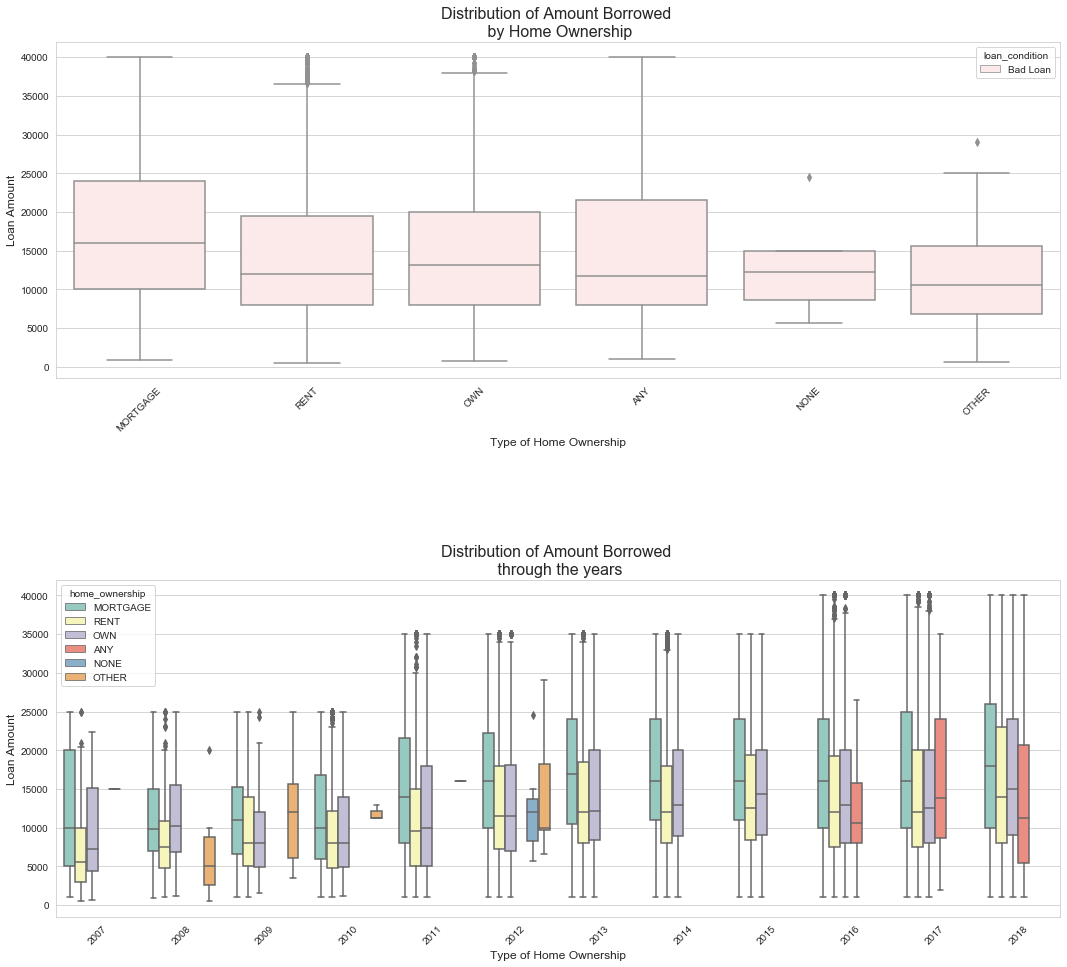

In [137]:
import seaborn as sns

plt.figure(figsize=(18,18))

# Create a dataframe for bad loans
bad_df = df.loc[df['loan_condition'] == 'Bad Loan']

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='loan_amount', hue='loan_condition',
               data=bad_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)



plt.subplot(212)
g1 = sns.boxplot(x='year', y='loan_amount', hue='home_ownership',
               data=bad_df, palette="Set3")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Type of Home Ownership", fontsize=12)
g1.set_ylabel("Loan Amount", fontsize=12)
g1.set_title("Distribution of Amount Borrowed \n through the years", fontsize=16)


plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

In [138]:

# Get the loan amount for loans that were defaulted by each region.
northe_defaults = df['loan_amount'].loc[(df['region'] == 'NorthEast') & (df['loan_status'] == 'Default')].values.tolist()
southw_defaults = df['loan_amount'].loc[(df['region'] == 'SouthWest') & (df['loan_status'] == 'Default')].values.tolist()
southe_defaults = df['loan_amount'].loc[(df['region'] == 'SouthEast') & (df['loan_status'] == 'Default')].values.tolist()
west_defaults = df['loan_amount'].loc[(df['region'] == 'West') & (df['loan_status'] == 'Default')].values.tolist()
midw_defaults = df['loan_amount'].loc[(df['region'] == 'MidWest') & (df['loan_status'] == 'Default')].values.tolist()

# Cumulative Values
y0_stck=northe_defaults
y1_stck=[y0+y1 for y0, y1 in zip(northe_defaults, southw_defaults)]
y2_stck=[y0+y1+y2 for y0, y1, y2 in zip(northe_defaults, southw_defaults, southe_defaults)]
y3_stck=[y0+y1+y2+y3 for y0, y1, y2, y3 in zip(northe_defaults, southw_defaults, southe_defaults, west_defaults)]
y4_stck=[y0+y1+y2+y3+y4 for y0, y1, y2, y3, y4 in zip(northe_defaults, southw_defaults, southe_defaults, west_defaults, midw_defaults)] 

# Make original values strings and add % for hover text
y0_txt=['$' + str(y0) for y0 in northe_defaults]
y1_txt=['$' + str(y1) for y1 in southw_defaults]
y2_txt=['$' + str(y2) for y2 in southe_defaults]
y3_txt=['$' + str(y3) for y3 in west_defaults]
y4_txt=['$'+ str(y4) for y4 in midw_defaults]

year = sorted(df["year"].unique().tolist())

NorthEast_defaults = go.Scatter(
    x= year,
    y= y0_stck,
    text=y0_txt,
    hoverinfo='x+text',
    name='NorthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(131, 90, 241)'),
    fill='tonexty'
)
SouthWest_defaults = go.Scatter(
    x=year,
    y=y1_stck,
    text=y1_txt,
    hoverinfo='x+text',
    name='SouthWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(255, 140, 0)'),
    fill='tonexty'
)

SouthEast_defaults = go.Scatter(
    x= year,
    y= y2_stck,
    text=y2_txt,
    hoverinfo='x+text',
    name='SouthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 128, 128)'),
    fill='tonexty'
)

West_defaults = go.Scatter(
    x= year,
    y= y3_stck,
    text=y3_txt,
    hoverinfo='x+text',
    name='West',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(135, 206, 235)'),
    fill='tonexty'
)

MidWest_defaults = go.Scatter(
    x= year,
    y= y4_stck,
    text=y4_txt,
    hoverinfo='x+text',
    name='MidWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 230, 140)'),
    fill='tonexty'
    )


data = [NorthEast_defaults, SouthWest_defaults, SouthEast_defaults, West_defaults, MidWest_defaults]

layout = dict(title = 'Amount Defaulted by Region',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Defaulted')
             )

fig = dict(data=data, layout=layout)
              
iplot(fig, filename='basic-area-no-bound')

In [139]:
df['interest_rate'].describe()
# Average interest is 13.26% Anything above this will be considered of high risk let's see if this is true.
df['interest_payments'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['interest_rate'] <= 13.23, 'interest_payments'] = 'Low'
    col.loc[col['interest_rate'] > 13.23, 'interest_payments'] = 'High'
    
df.head()

,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,emp_length,home_ownership,...,settlement_percentage,settlement_term,year,loan_condition,region,complete_date,emp_length_int,income_category,loan_condition_int,interest_payments
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,10+ years,RENT,...,NaN,NaN,2018,Good Loan,NorthEast,2018-12-01,10.0,Low,0,High
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,10+ years,MORTGAGE,...,NaN,NaN,2018,Good Loan,SouthEast,2018-12-01,10.0,Low,0,High
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,6 years,MORTGAGE,...,NaN,NaN,2018,Good Loan,MidWest,2018-12-01,6.0,Low,0,High
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,10+ years,MORTGAGE,...,NaN,NaN,2018,Good Loan,West,2018-12-01,10.0,Low,0,High
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,10+ years,MORTGAGE,...,NaN,NaN,2018,Good Loan,NorthEast,2018-12-01,10.0,Low,0,High


In [140]:
df['term'].value_counts()

 36 months    1609754
 60 months     650914
Name: term, dtype: int64

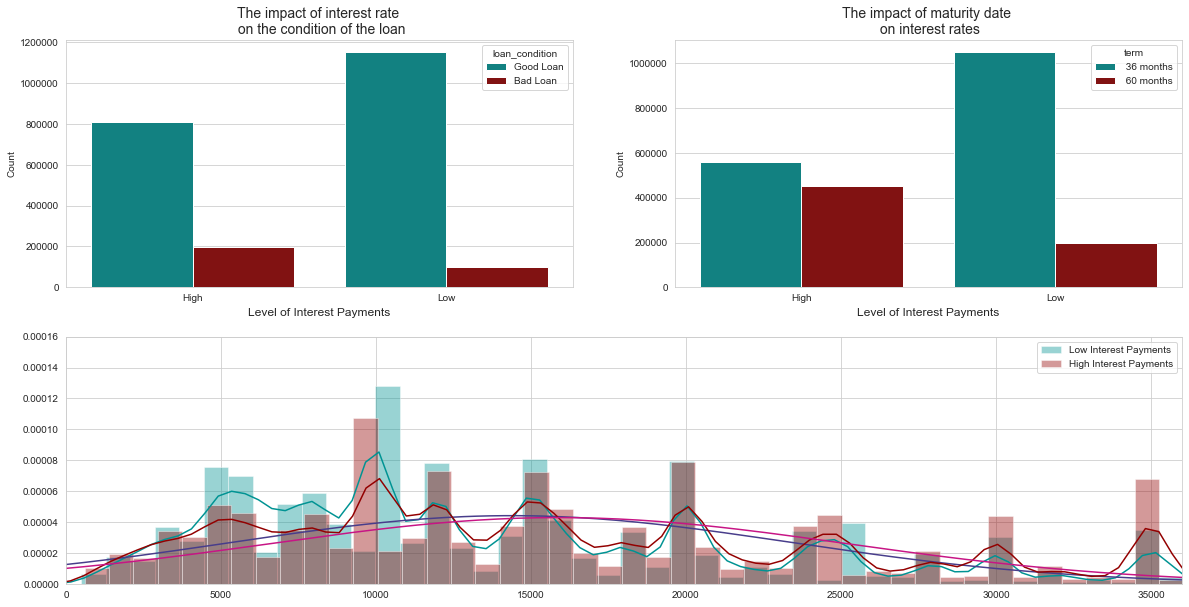

In [141]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_payments', data=df, 
                  palette=palette, hue='loan_condition')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
ax1 = sns.countplot(x='interest_payments', data=df, 
                   palette=palette, hue='term')

ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')


plt.subplot(212)
low = df['loan_amount'].loc[df['interest_payments'] == 'Low'].values
high = df['loan_amount'].loc[df['interest_payments'] == 'High'].values


ax2= sns.distplot(low, color='#009393', label='Low Interest Payments', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
ax3 = sns.distplot(high, color='#930000', label='High Interest Payments', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
plt.axis([0, 36000, 0, 0.00016])
plt.legend()


plt.show()

In [142]:

# Interest rate good loans
avg_fully_paid = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Fully Paid'].values), 2)
avg_current = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Current'].values), 2) 
avg_issued = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Issued'].values), 2)
avg_long_fully_paid = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].values), 2)



# Interest rate bad loans

avg_default_rates = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Default'].values), 2)
avg_charged_off = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Charged Off'].values), 2)
avg_long_charged_off = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].values), 2)
avg_grace_period = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'In Grace Period'].values), 2)
avg_short_late = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Late (16-30 days)'].values), 2)
avg_long_late = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Late (31-120 days)'].values), 2)


# Take to a dataframe

data = [
    go.Scatterpolar(
        mode='lines+markers',
      r = [avg_fully_paid, avg_current, avg_issued, avg_long_fully_paid],
      theta = ['Fully Paid', 'Current', 'Issued', 'No C.P. Fully Paid'],
      fill = 'toself',
      name = 'Good Loans',
        line = dict(
        color = "#63AF63"
      ),
      marker = dict(
        color = "#B3FFB3",
        symbol = "square",
        size = 8
      ),
      subplot = "polar",
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = [avg_default_rates, avg_charged_off, avg_long_charged_off, avg_grace_period, avg_short_late, avg_long_late],
      theta = ['Default Rate', 'Charged Off', 'C.P. Charged Off', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)'],
      fill = 'toself',
      name = 'Bad Loans',
        line = dict(
        color = "#C31414"
      ),
      marker = dict(
        color = "#FF5050",
        symbol = "square",
        size = 8
      ),
      subplot = "polar2"
    )
]

layout = go.Layout(
    title="Average Interest Rates <br> Loan Status Distribution",
    showlegend = False,
     paper_bgcolor = "rgb(255, 248, 243)",
    polar = dict(
      domain = dict(
        x = [0,0.4],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 8
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.6,1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 8
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='polar')

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



In [143]:
df['purpose'].value_counts()

# Education, renewable energy, wedding are the purposed that contains highest bad loans percent wise.

purpose_condition = round(pd.crosstab(df['loan_condition'], df['purpose']).apply(lambda x: x/x.sum() * 100), 2)

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns


bad_plot = go.Bar(
    x=purpose,
    y=purpose_bad_loans,
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose,
    y=purpose_good_loans,
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

In [144]:
# Average interest by income category and purposes 
# Which purpose carries a higher interest rate and does income category have an influence on risk?
# Is LendingClub deploying loan amount where there is a high risk (interest_rate)
# Remember we learned that interest_rates is a key metric in evaluating risk.



group_income_purpose = df.groupby(['income_category', 'purpose'], as_index=False).interest_rate.mean()
group_dti_purpose = df.groupby(['income_category', 'purpose'], as_index=False).loan_amount.mean()
loan_a = group_dti_purpose['loan_amount'].values



# High Car 10.32 15669
new_groupby = group_income_purpose.assign(total_loan_amount=loan_a)
sort_group_income_purpose = new_groupby.sort_values(by="income_category", ascending=True)

In [145]:
loan_count = df.groupby(['income_category', 'purpose'])['loan_condition'].apply(lambda x: x.value_counts())
d={"loan_c": loan_count}
loan_c_df = pd.DataFrame(data=d).reset_index()
loan_c_df = loan_c_df.rename(columns={"level_2": "loan_condition"})


# Good loans & Bad Loans
good_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Good Loan"].sort_values(by="income_category", ascending=True)
bad_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Bad Loan"].sort_values(by="income_category", ascending=True)
sort_group_income_purpose['good_loans_count'] = good_loans['loan_c'].values
sort_group_income_purpose['bad_loans_count'] = bad_loans['loan_c'].values
sort_group_income_purpose['total_loans_issued'] = (good_loans['loan_c'].values + bad_loans['loan_c'].values)
sort_group_income_purpose['bad/good ratio (%)'] = np.around(bad_loans['loan_c'].values / (bad_loans['loan_c'].values + good_loans['loan_c'].values), 4) * 100
final_df = sort_group_income_purpose.sort_values(by='income_category', ascending=True)
final_df.style.background_gradient('coolwarm')

,income_category,purpose,interest_rate,total_loan_amount,good_loans_count,bad_loans_count,total_loans_issued,bad/good ratio (%)
0,High,car,10.7707,18261.8,371,27,398,6.78
6,High,major_purchase,11.865,23518.8,1225,108,1333,8.1
1,High,credit_card,10.483,26483.8,11502,814,12316,6.61
2,High,debt_consolidation,11.9964,26566.3,23924,2392,26316,9.09
4,High,home_improvement,11.4999,25283.3,6341,619,6960,8.89
5,High,house,13.4026,27674.7,497,47,544,8.64
10,High,renewable_energy,13.9004,23222.9,22,2,24,8.33
3,High,educational,11.42,11000,1,1,2,50
8,High,moving,13.4618,20310.1,297,26,323,8.05
9,High,other,13.0708,22356.9,2824,293,3117,9.4


In [146]:
final_df = final_df.sort_values(by="purpose", ascending=False)

In [147]:
# Work on a plot to explain better the correlations between the different columns in final_df dataframe.
# We will do a Subplot in Plotly with 



# Labels
purpose_labels = df['purpose'].unique()

# Average Interest Rate Dot Plots # 1st Subplot
high_income = final_df['interest_rate'].loc[final_df['income_category'] == 'High'].values.tolist()
medium_income = final_df['interest_rate'].loc[final_df['income_category'] == 'Medium'].values.tolist()
low_income = final_df['interest_rate'].loc[final_df['income_category'] == 'Low'].values.tolist()

high_lst = ['%.2f' % val for val in high_income]
med_lst = ['%.2f' % val for val in medium_income]
low_lst = ['%.2f' % val for val in low_income]



trace1 = {"x": high_lst,
          "y": purpose_labels,
          "marker": {"color": "#0040FF", "size": 16},
          "mode": "markers",
          "name": "High Income",
          "type": "scatter"
}

trace2 = {"x": med_lst,
          "y": purpose_labels,
          "marker": {"color": "#FE9A2E", "size": 16},
          "mode": "markers",
          "name": "Medium Income",
          "type": "scatter",
}

trace3 = {"x": low_lst,
          "y": purpose_labels,
          "marker": {"color": "#FE2E2E", "size": 16},
          "mode": "markers",
          "name": "Low Income",
          "type": "scatter",
}




data = [trace1, trace2, trace3]
layout = {"title": "Average Purpose Interest Rate <br> <i> by Income Category </i> ",
          "xaxis": {"title": "Average Interest Rate", },
          "yaxis": {"title": ""}}

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [148]:
# Labels
purpose_labels = final_df['purpose'].unique()

# Amount of Good and Bad Loans per Purpose (fill by income category)
# Good Loans
good_high_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "High"].values.tolist()
good_med_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "Medium"].values.tolist()
good_low_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "Low"].values.tolist()

# Bad Loans
bad_high_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "High"].values.tolist()
bad_med_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "Medium"].values.tolist()
bad_low_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "Low"].values.tolist()


# Good Loans
trace0 = go.Bar(
    y=purpose_labels,
    x=good_high_cnt,
    legendgroup='a',
    name='High Income',
    orientation='h', 
    marker=dict(
        color='#0040FF'
    )
)
trace1 = go.Bar(
    x=good_med_cnt,
    y=purpose_labels,
    legendgroup='a',
    name='Medium Income',
    orientation='h',
    marker=dict(
        color='#FE9A2E',
    )
)

trace2 = go.Bar(
    x=good_low_cnt,
    y=purpose_labels,
    legendgroup='a',
    name='Low Income',
    orientation='h',
    marker=dict(
        color='#FE2E2E',
    )
)

# Bad Loans issued by Income Category
trace3 = go.Bar(
    y=purpose_labels,
    x=bad_high_cnt,
    legendgroup='b',
    showlegend=False,
    name='High Income',
    orientation='h', 
    marker=dict(
        color='#0040FF'
    )
)
trace4 = go.Bar(
    x=bad_med_cnt,
    y=purpose_labels,
    legendgroup='b',
    showlegend=False,
    name='Medium Income',
    orientation='h',
    marker=dict(
        color='#FE9A2E',
    )
)

trace5 = go.Bar(
    x=bad_low_cnt,
    y=purpose_labels,
    legendgroup='b',
    showlegend=False,
    name='Low Income',
    orientation='h',
    marker=dict(
        color='#FE2E2E',
    )
)



fig = tools.make_subplots(rows=2, cols=1, print_grid=False,
                         subplot_titles=("Amount of <br> <i>Good Loans Issued</i>",
                                        "Amount of <br> <i>Bad Loans Issued</i>")
                         )

# First Subplot
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

# Second Subplot
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 1)

fig['layout'].update(height=800, width=800, title='Issuance of Loans', showlegend=True, xaxis=dict(title="Number of Loans Issued"))
iplot(fig, filename='angled-text-bar')

/usr/local/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [149]:
# Next task a Radar Chart with the bad/good ratio to see if it justifies the amount of loans issued towards housing
high_ratio = final_df.loc[final_df['income_category'] == 'High']
medium_ratio = final_df.loc[final_df['income_category'] == 'Medium']
low_ratio = final_df.loc[final_df['income_category'] == 'Low']

data = [
    go.Scatterpolar(
        mode='lines+markers',
      r = high_ratio['bad/good ratio (%)'].values.tolist(),
      theta = high_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'High Income',
        line = dict(
        color = "#63AF63"
      ),
      marker = dict(
        color = "#B3FFB3",
        symbol = "square",
        size = 8
      ),
      subplot = "polar",
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = medium_ratio['bad/good ratio (%)'].values.tolist(),
      theta = medium_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'Medium Income',
        line = dict(
        color = "#C31414"
      ),
      marker = dict(
        color = "#FF5050",
        symbol = "square",
        size = 8
      ),
      subplot = "polar2"
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = low_ratio['bad/good ratio (%)'].values.tolist(),
      theta = low_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'Low Income',
        line = dict(
        color = "#C9FFC7"
      ),
      marker = dict(
        color = "#8CB28B",
        symbol = "square",
        size = 8
      ),
      subplot = "polar3"
    ),
]

layout = go.Layout(
    title="Bad/Good Ratio <br> (By Purpose)",
    showlegend = False,
     paper_bgcolor = "rgb(255, 206, 153)",
    polar = dict(
      domain = dict(
        x = [0,0.3],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.35,0.65],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 85,
        direction = "clockwise"
      ),
    ),
    polar3 = dict(
      domain = dict(
        x = [0.7, 1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    ))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "multiple")